### Задание 1 .
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.  
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

### Решение:
Подгрузим библиотеки и датасет.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

excel_data = pd.read_excel('AB_Test_Results.xlsx');
df = pd.DataFrame(excel_data, columns=['USER_ID', 'VARIANT_NAME', 'REVENUE'])

print("The content of the file is:\n", df)


The content of the file is:
       USER_ID VARIANT_NAME  REVENUE
0         737      variant      0.0
1        2423      control      0.0
2        9411      control      0.0
3        7311      control      0.0
4        6174      variant      0.0
...       ...          ...      ...
9995     1981      control      0.0
9996      502      variant      0.0
9997     9214      variant      0.0
9998     7741      control      0.0
9999     9468      control      0.0

[10000 rows x 3 columns]


Датасет содержит данные с ID пользователя, Распрделением по группам для A/B теста и доходом, полученным от пользователя.  
По эти данным сформулируем нулевую гипотезу:<br>
**Средняя выручка, полученная от пользователей в контрольной и тестовой группе не имеет статистически значимых отличий.**<br>
Для начала нужно проверить данные на корректрость.

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [87]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [88]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Проверка на пропуски показала, что в тетасете пропущенных значений нет.

In [89]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Контрольная и тестовая группы имеют примерно равное количество пользователей.

In [90]:
v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [91]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


А проверка на принадлежность пользователей той или иной группе показала, что некоторые  
пользователи попали одновременно и в контрольную, и в тестовую группу. Такие данные из  
датасета нужно исключить.

In [92]:
more_than_one_types = v.query('VARIANT_NAME > 1')

In [93]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [94]:
df.shape

(10000, 3)

In [95]:
df_new.shape

(6070, 3)

И видим, что после создания датафрейма с исключенными дублями записей, размерность  
наших данных сократилась примерно на 40%. И здесь уже можно поставить вопрос о корректности  
проводимого эксперимента. <br>
Скорее всего алгоритм распределения пользователей по группам имел ошибки и лучшим вариантом  
было бы данный эксперимент свернуть и начать новый с данными, полученными после исправления  
алгоритма распределения пользователей на группы. <br>
Но, продолжим изучение данных и посмотрим на распределение пользователей по группам после  
удаления дубликатов.

In [96]:
control = df_new.query('VARIANT_NAME == "control"')
test = df_new.query('VARIANT_NAME == "variant"')

In [97]:
len(control)

3026

In [98]:
len(test)

3044

Пользователей в группах примерно поровну.  
Для определения того, соответствует ли выборка нормальному распределению, воспользуемся тестом Шапиро-Уилка.  
Если p-значение ниже определенного уровня значимости, то у нас есть достаточно доказательств, чтобы сказать,  
что данные выборки не получены из нормального распределения.

In [99]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



Тест показывает, что распределение не нормальное, в чем можно визуально убедиться, построив графики для обеих групп.

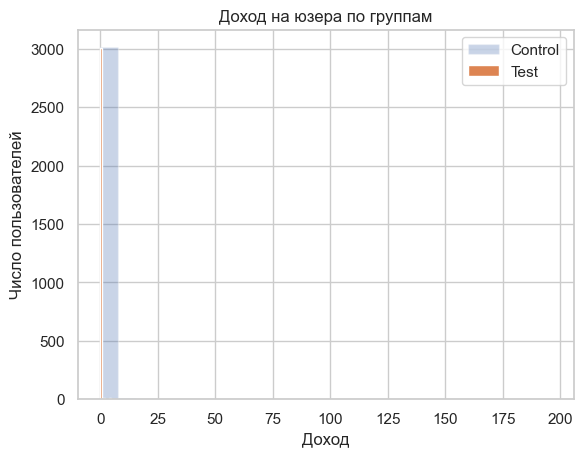

In [100]:
control.REVENUE.hist(bins = 25, alpha = 0.3, label='Control')
test.REVENUE.hist(bins = 25, alpha =1, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Таким образом, используем U- критерий Манна-Уитни для сравнения различий между двумя выборками, когда распределение выборки не является нормальным, а размеры выборки малы.

In [101]:
mw_stats = mannwhitneyu(x = control.REVENUE.values, y = test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

Итак, можно подвести итоги. Но, чтобы исключить возможные ошибки II рода,  
нужно еще провести расчет статистической мощности.  
Более интуитивно статистическую мощность можно рассматривать как вероятность  
принятия альтернативной гипотезы, когда альтернативная гипотеза верна.  
При интерпретации статистической мощности мы ищем эмпирические установки,  
обладающие высокой статистической мощностью.<br>
* Низкая статистическая мощность: большой риск совершения ошибок типа II, т.е. ложный отрицательный результат.
* Высокая статистическая мощность: небольшой риск совершения ошибок типа II.

Библиотека statsmodels предоставляет класс TTestIndPower для расчета анализа мощности для критерия Стьюдента с независимыми выборками. Им и воспользуемся.

In [102]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

In [103]:
n =  len(control.REVENUE.values)

In [104]:
S = np.sqrt((T_std ** 2 + C_std ** 2) / 2)

In [105]:
effect =float((T_mean - C_mean) / S) 

In [106]:
alpha = 0.05

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.28936707257547545

### Выводы
Ссылаясь на значение 0.289367, можем утверждать, что мощность проведенного теста очень низкая. Таким образом, мы никак не можем отвергнуть нулевую гипотезу, утверждающую, что **средняя выручка, полученная от пользователей в контрольной и тестовой группе не имеет статистически значимых отличий**.

### Рекомендации
Датасет для решения поставленной задачи с целью увеличить доход содержит данные, искажающие  
реальную картину получения прибыли. Скорее всего алгоритм распределения пользователей по  
группам имел ошибки и лучшим вариантом было бы данный эксперимент свернуть и начать новый  
с данными, полученными после исправления алгоритма распределения пользователей на группы.  
А также можно рекоменовадать увеличить объем данных в датасете для большей валидности  
проводимого эксперимента. Задав уровень мощности в 80%, можем вновь воспользоваться  
классом TTestIndPower только теперь для оценки подходящего размера выборки. То есть,  
сколько наблюдений требуется от каждой выборки, чтобы по крайней мере обнаружить эффект  
0,80 с вероятностью обнаружения эффекта 80%, если он истинен (20% ошибки типа II) и  
вероятностью обнаружения 5%. эффект, если такого эффекта нет (ошибка первого рода).

In [107]:
alpha = 0.05

analysis = TTestIndPower()
result = analysis.solve_power(effect, power = 0.8,
nobs1 = None, ratio = 1.0, alpha = alpha)

result

12052.666064035826

***Значит, для качественного повторного проведения A/B теста требуется датасет без дублей пользователей  
в тестовой и контрольной группах и с разменами этих групп 12060.***